# Tarea 4 - SVM y Redes Neuronales

## SVM

In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, PredefinedSplit, GridSearchCV

In [2]:
data = loadmat('xdata.mat')

In [3]:
X_train = data['Xtrain']
y_train = data['ytrain']
X_val = data['Xval']
y_val = data['yval']
X_test = data['Xtest']
y_test = data['ytest']

Tras cargar la información se procede a mirar los resultados de un SVM sin ningún tipo de modificación de hiperparámetros:

In [4]:
def scores(model, only_print=False):
    test = model.score(X_test, y_test.ravel())
    val = model.score(X_val, y_val.ravel())
    train = model.score(X_train, y_train.ravel())
    if not only_print:
        return train, val, test
    print('Train: %s, Val: %s, Test: %s' % (train, val, test))

In [5]:
svc = SVC(gamma='scale')
svc.fit(X_train, y_train.ravel())
scores(svc, only_print=True)

Train: 0.884, Val: 0.89, Test: 0.8666666666666667


El rendimiento a priori es bastante aceptable, sin embargo, vamos a ver qué se puede hacer con los parámetros para obtener mejores resultados.

In [6]:
X_all = np.vstack((X_train, X_val))
y_all = np.vstack((y_train, y_val))

Se define un `PredefinedSplit` para respetar la división de los sets entregada por el profesor:

In [7]:
fold = np.append(np.full((X_train.shape[0],), -1, dtype=int), np.zeros(X_val.shape[0], dtype=int))
ps = PredefinedSplit(fold)

### Elección del parámetro $\gamma$

Para escoger $\gamma$ lo que se va a hacer es utilizar la función `validation_curve` entregandole el modelo y los valores sobre los que se quiere probar.

Para la elección del dominio de `gamma` se exploró en la literatura, y en [este documento](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) se explicaba que es buena idea utilizar potencias de 2 desde $2^{-15}$ hasta $2^{3}$, se escogío un rango similar, las potencias de 2 entre -10 y 5. 

In [8]:
gamma_range = np.power(2, np.linspace(-10, 5, 16))
train_scores, valid_scores = validation_curve(
    SVC(), X_all, y_all.ravel(), "gamma", gamma_range, cv=ps
)

Una vez obtenidos los resultados, es posible graficarlos para ver como se comportan:

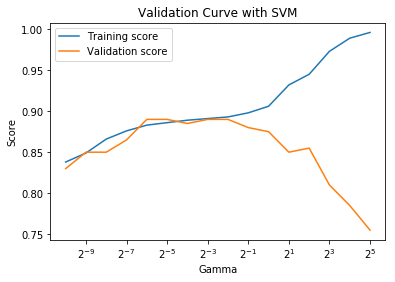

In [9]:
plt.title("Validation Curve with SVM")
plt.xlabel("Gamma")
plt.ylabel("Score")

plt.semilogx(gamma_range, train_scores, basex=2, label="Training score")
plt.semilogx(gamma_range, valid_scores, basex=2, label="Validation score")
plt.legend(loc='best')
plt.show()

Como se comentó en clases, la elección de los parámetros debe hacerse de modo que sea el punto donde el set de validación deja de mejorar, ya que training va a seguir subiendo. Para eso se obtiene el máximo de los _scores_ de validación.

In [10]:
index = np.where(valid_scores.ravel() == max(valid_scores.ravel()))
gamma_range[index]

array([0.015625, 0.03125 , 0.125   , 0.25    ])

Como son varios que otorgan el mismo puntaje en validación, un supuesto es decir que el mejor es aquel que entrega mejor puntaje en training, y ese es el último.

In [11]:
svc = SVC(gamma=gamma_range[index][-1])
svc.fit(X_train, y_train.ravel())
scores(svc, only_print=True)

Train: 0.893, Val: 0.89, Test: 0.8733333333333333


De este modo, solo con modificar el `gamma`, se obtiene ya un resultado mejor, sin embargo, es muy poca la diferencia.

### Elección del parámetro C

Con el mismo documento anterior, y con similares argumentos, se utiliza el sioguiente rango, de $2^{-5}$ a $2^{15}$ para probar los valores de C.

In [12]:
C_range = np.power(2, np.linspace(-5, 15, 61))
train_scores, valid_scores = validation_curve(
    SVC(gamma='scale'), X_all, y_all.ravel(), "C", C_range, cv=ps
)

Del mismo modo, se puede proceder a graficar el parámetro:

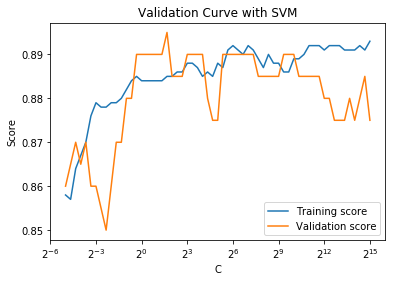

In [13]:
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")

plt.semilogx(C_range, train_scores, basex=2, label="Training score")
plt.semilogx(C_range, valid_scores, basex=2, label="Validation score")
plt.legend(loc='best')
plt.show()

In [14]:
index = np.where(valid_scores.ravel() == max(valid_scores.ravel()))
C_range[index]

array([3.1748021])

Cabe notar que oscila mucho más y esto puede deberse al significado del parámetro C. Sin embargo, realizando la misma elección, aquella que maximiza al valor de validación, se obtiene lo siguiente:

In [15]:
svc = SVC(C=C_range[index], gamma='scale')
svc.fit(X_train, y_train.ravel())
scores(svc, only_print=True)

Train: 0.885, Val: 0.895, Test: 0.87


Resultados mejores que sin ajuste de nada, pero peores que con el ajuste exclusivo de `gamma`.

### Elección conjunta de C y $\gamma$

Utilizando rangos similares para los parámetros, pero menos datos por la gran cantidad de computaciones a realizar, se procede a realizar una evaluación conjunta de los parámetros, esto es, sin dejar fijo uno para mover el otro, sino que moviendo ambos a la vez.

Para esto se utiliza la función `GridSearchCV` utilizando la misma división del set de datos.

In [16]:
C_range = np.power(2, np.linspace(-5, 6, 12))
gamma_range = np.power(2, np.linspace(-10, 1, 12))
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=ps, return_train_score=True)
grid.fit(X_all, y_all.ravel())

print(f'Params: {grid.best_params_}, Score: {grid.best_score_}')

Params: {'C': 4.0, 'gamma': 0.015625}, Score: 0.895


Una vez que se obtienen los parámetros, que justamente tienen valores distintos a los obtenidos singularmente en cada experimento por separado, se procede a ver los scores en los 3 sets.

In [17]:
svc = SVC(**grid.best_params_)
svc.fit(X_train, y_train.ravel())
scores(svc, only_print=True)

Train: 0.885, Val: 0.895, Test: 0.8733333333333333


Como se observa este es el experimento que mejor resultados ha dado en _validation_. Dado que no se debe entrenar mirando los resultados de _test_, podemos decir que esos son los dos mejores valores para C y `gamma`, empatados con los de la sección anterior, moviendo C pero sin mover `gamma`.

Para visualizar un poco lo mismo que se hizo antes, es importante notar que ahora se necesitan visualizaciones tridisimensionales.

In [18]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [19]:
train_scores = grid.cv_results_['mean_train_score']
valid_scores = grid.cv_results_['mean_test_score']

Se mostrará un gráfico de superficies 3D con un punto que muestre la elección de los parámetros óptimos.

Por limitaciones de la librería, no se pueden ajustar los ejes a una escala logarítmica como se hizo anteriormente, de modo que se mostrará una sección reducida del gráfico, para que se ilustre mejor

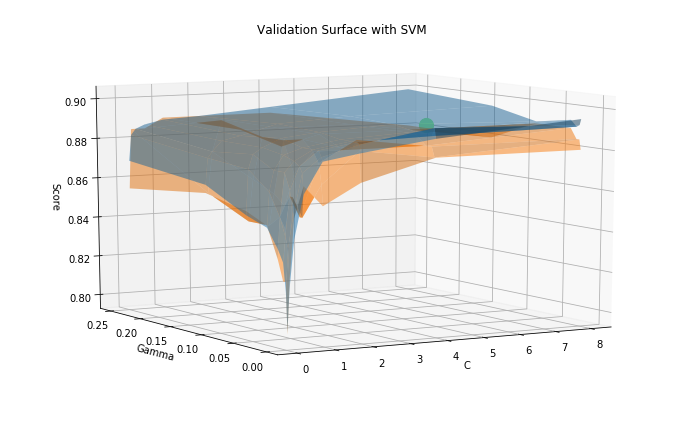

In [20]:
N = 9
n = 1
C, gamma = np.meshgrid(C_range[n:N], gamma_range[n:N])

fig = plt.figure(figsize=(12, 7.5))
ax = fig.gca(projection='3d')
ax.set_title('Validation Surface with SVM')
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Score')

train_scores_plot = train_scores.reshape((C_range.shape[0], gamma_range.shape[0]))[n:N, n:N]
valid_scores_plot = valid_scores.reshape((C_range.shape[0], gamma_range.shape[0]))[n:N, n:N]

ax.plot_surface(C, gamma, train_scores_plot, linewidth=0, alpha=0.5)
ax.plot_surface(C, gamma, valid_scores_plot, linewidth=0, alpha=0.5)
ax.scatter(4.0, 0.015625, 0.895, color='lightgreen', s=200)
ax.view_init(10, 240)
plt.show()

El punto verde ilustra más o menos donde se ubican los valores óptimos en cuando a las curvas, siendo la naranja la de los resultados de validación y la azul de entrenamiento. En ciertas zonas para C altos, se nota que la curva naranja empieza a descender después del punto verde, y que la azul sigue subiendo, lo que nos habla de como ese es el punto que hay que escoger.

Sin embargo, la visualización no es tan ilustrativa, para lo que se entrega la siguiente, un mapa de calor que ilustra en la temperatura el puntaje máximo, y en los ejes los valores para C y $\gamma$.

Esta visualización nos muestra que el máximo efectivamente se da donde habíamos escogido.

Para que la visualización sea más fructífera, se utiliza una normalización que permite solo enfocarnos en la parte de los puntajes que es importante (alrededor del 0.88) y no en todo el espectro. Parte del código fue extraido de la documentación de sklearn [aquí](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

In [21]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

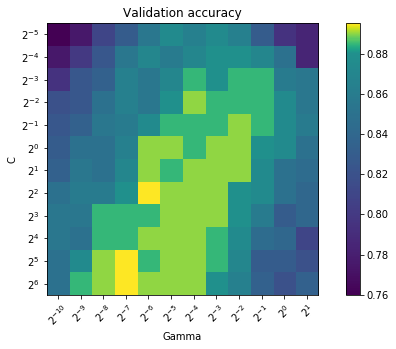

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(
    valid_scores.reshape((C_range.shape[0], gamma_range.shape[0])),
    interpolation='nearest',
    cmap=plt.cm.viridis,
    norm=MidpointNormalize(midpoint=0.88)
)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.colorbar()
pow2_label = lambda x: '$2^{%s}$' % int(x)
plt.xticks(np.arange(gamma_range.shape[0]), [pow2_label(i) for i in np.log2(gamma_range)], rotation=45)
plt.yticks(np.arange(C_range.shape[0]), [pow2_label(i) for i in np.log2(C_range)])
plt.title('Validation accuracy')
plt.show()

Como se observa, los puntos de mayor temperatura, es decir, los de puntaje más alto, se dan en los valores de `gamma` y de C escogidos.

Ahora se mostrará el gráfico que se obtiene de la separación dada por el clasificador escogido, esto es, los puntos con sus clases, y la separación que realiza el SVM. Para esto se utilizan mapas de calor, _scatter plots_ y técnicas comunes de matplotlib. Inspirado en [este ejemplo](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

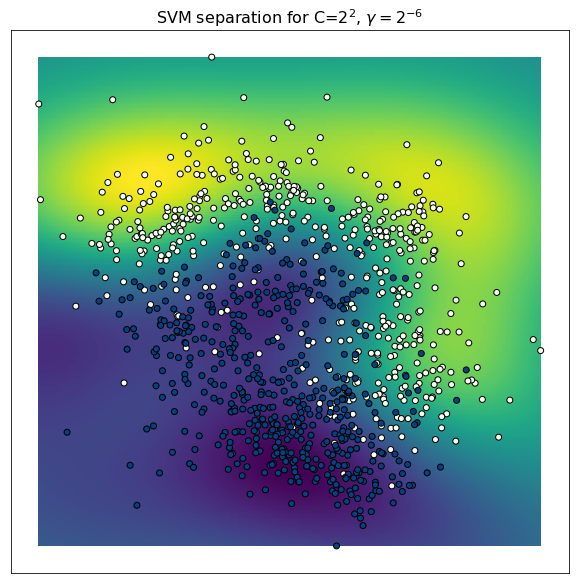

In [28]:
plt.figure(figsize=(10, 10))
x1, x2 = np.meshgrid(
    np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 200),
    np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 200)
)

C = grid.best_params_['C']
gamma = grid.best_params_['gamma']
clf = SVC(**grid.best_params_)
clf.fit(X_train, y_train.ravel())

y = clf.decision_function(np.column_stack((x1.ravel(), x2.ravel()))).reshape(x1.shape)

plt.title("SVM separation for C=$2^{%d}$, $\gamma=2^{%d}$" % (np.log2(C), np.log2(gamma)),
          fontdict={'fontsize': 16})

plt.pcolormesh(x1, x2, -y, cmap=plt.cm.viridis)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(),
            cmap=plt.cm.GnBu, edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis('tight')
plt.show()

Como se observa, la separación es bastante buena, y no tiene sentido que sea mucho mejor puesto que hay puntos blancos que claramente están dentro de la clase azul, lo que haría virtualmente imposible una separación perfecta.

Con esto, volviendo un poco hacia atrás, para los valores:

In [29]:
grid.best_params_

{'C': 4.0, 'gamma': 0.015625}

Los resultados obtenidos son:

In [30]:
scores(svc, only_print=True)

Train: 0.885, Val: 0.895, Test: 0.8733333333333333


Que justamente son los mejores resultados en validación de todos los experimentos. Sin embargo, están empatados con los resultados obtenidos en la sección de solo C.

De todos modos, un supuesto válido es que al haber probado con ambos parámetros al mismo tiempo se tiene un modelo más robusto, por lo que se eligen estos parámetros.

Sin desmedro de lo anterior, estos resultan ser también los más altos para _test_, pero la diferencia respecto a lo anterior es marginal, $0.873333$ vs $0.87$.

## Redes Neuronales

In [31]:
%reset -f array

In [32]:
X_train = data['Xtrain']
y_train = data['ytrain']
X_val = data['Xval']
y_val = data['yval']
X_test = data['Xtest']
y_test = data['ytest']
X_all = np.vstack((X_train, X_val))
y_all = np.vstack((y_train, y_val))

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

Para esta sección se utilizan las redes neuronales de `sklearn` junto con el normalizador para los datos, donde al igual que en tareas anteriores, se normaliza o _escala_ el entrenamiento y con los mismos parámetros se transforman los otros sets.

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_all = scaler.transform(X_all)

Un primer intento considera una red neuronal con pocos parametros modificados.

In [111]:
scs = np.array([(0., 0., 0.) for _ in range(10)])
for i in range(10):
    nn = MLPClassifier(solver='lbfgs', activation='tanh')
    nn.fit(X_train, y_train.ravel());
    scs[i] = scores(nn)

In [113]:
print('Train: %s, Val: %s, Test: %s' % tuple(scs.mean(axis=0)))

Train: 0.8963000000000001, Val: 0.8785000000000001, Test: 0.8653333333333334


Como se aprecia, el rendimiento es muy bueno, de alrededor de $87.8\%$ en validación sin ningún tipo de búsqueda de parámetros.

Ahora, para hacer una búsqueda, se hace lo mismo que antes pero con más parámetros, variando entre tipos de funciones de activación, tasa de aprendizaje, tamaño de las capas, etc.

Se utiliza el parámetro `n_jobs=-1` con la intención de paralelizar la búsqueda. Además nuevamente se incluye el mismo `PredefinedSplit` para respetar los cortes en el set pedidos por el profesor.

In [114]:
parameters = {
    'solver': ['lbfgs'],
    'learning_rate': ['invscaling', 'adaptive'],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [300, 400],
    'alpha': 10.0 ** -np.arange(4, 7),
    'random_state': [2],
    'hidden_layer_sizes': np.linspace(10, 100, 10, dtype=int),
}
nn_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=ps)

In [115]:
nn_grid.fit(X_all, y_all.ravel());

In [116]:
print(f'Params: {nn_grid.best_params_}, Score: {nn_grid.best_score_}')

Params: {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': 90, 'learning_rate': 'invscaling', 'max_iter': 300, 'random_state': 2, 'solver': 'lbfgs'}, Score: 0.9


Si bien la búsqueda otorga ciertos parámetros, se observa que las variaciones son mínimas entre un método y otro y que suelen variar más por el estado aleatorio inicial, que por los parámetros mismos. Esto lleva a pensar que el ajuste es bastante adecuado sin una búsqueda exhaustiva de los hiperparámetros, y que los puntajes que se dan por el ajuste correcto que realiza la red neuronal, y puede deberse a la simpleza del problema en cuestión.

In [124]:
params_to_average = {key: value for key, value in nn_grid.best_params_.items() if key != 'random_state'}
scs = np.array([(0., 0., 0.) for _ in range(10)])
for i in range(10):
    nn = MLPClassifier(**params_to_average)
    nn.fit(X_train, y_train.ravel())
    scs[i] = scores(nn)

In [125]:
print('Train: %s, Val: %s, Test: %s' % tuple(scs.mean(axis=0)))

Train: 0.8955, Val: 0.8799999999999999, Test: 0.8706666666666667


Para esta sección se obtienen resultados bastante satisfactorios en validación y training, y son levemente superiores que los obtenidos en una primera iteración sin ajuste de parámetros.

Ahora, se procede a mostrar un gráfico similar al de la sección de SVM, sin embargo, para esta ocasión, los clasificadores de redes neuronales no entregan una función de decisión, sino que una función de probabilidad que entrega la probabilidad para cada muestra de estar en la clase.

Con eso, se muestra a modo de grilla de colores la separación que está realizando la red neuronal, y se muestran los puntos encima de ella para ver la clasificación. Para este gráfico me basé en lo mismo de la sección anterior y parte de [este artículo](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

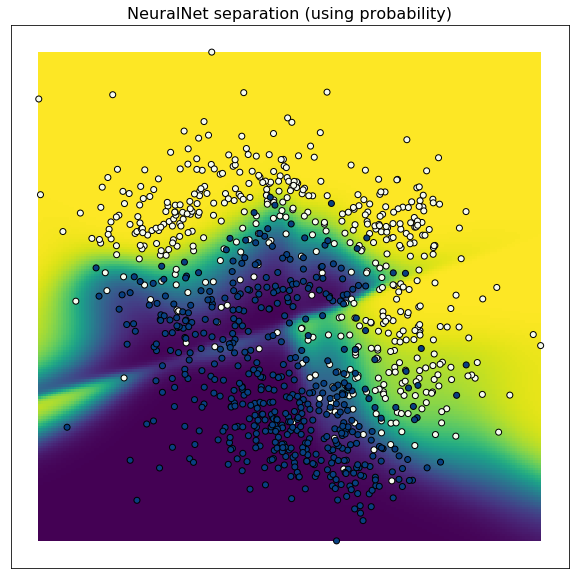

In [126]:
plt.figure(figsize=(10, 10))
x1, x2 = np.meshgrid(
    np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 200),
    np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 200)
)

nn = MLPClassifier(**nn_grid.best_params_)
nn.fit(X_train, y_train.ravel())
y = nn.predict_proba(np.column_stack((x1.ravel(), x2.ravel())))[:, 1].reshape(x1.shape)

plt.title("NeuralNet separation (using probability)", fontdict={'fontsize': 16})
plt.pcolormesh(x1, x2, -y, cmap=plt.cm.viridis, alpha=1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(),
            cmap=plt.cm.GnBu, edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis('tight')
plt.show()

Como se observa, la separación pareciera ser un poco mejor, pero pareciera estar sobreajustando, dado que genera formas abruptas en lugares donde hay puntos que podríamos llamar _outliers_. Además se ve bastante no lineal, y eso muestra como funcionan las redes neuronales, que capturan la no linealidad que a veces es más compleja de obtener en otro tipo de clasificadores.

Volviendo a lo anterior, se aprecia que los resultados obtenidos promediados tras la búsqueda son de un $88\%$ en validación y de un $87.3\%$ en test.